In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from matplotlib.transforms import Affine2D

from PIL import Image

import skimage.io
import skimage.color
import skimage.exposure
from skimage.color import rgb2gray

from scipy import signal
from scipy.ndimage import sobel, gaussian_filter, maximum_filter, convolve

# Data loader

View 1 resolution: 1000x664
View 2 resolution: 1000x664


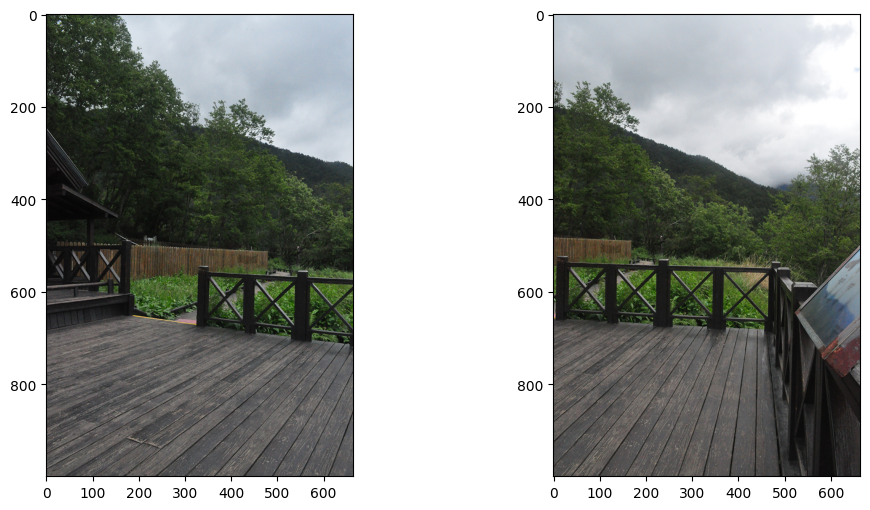

In [4]:
##### Need image database

##### Testing
# Load images and resize
VIEW1 = np.array(Image.open("data/xue-mountain/01.jpg")) / 255
VIEW2 = np.array(Image.open("data/xue-mountain/02.jpg")) / 255

# Check resolution
print(f"View 1 resolution: {VIEW1.shape[0]}x{VIEW1.shape[1]}")
print(f"View 2 resolution: {VIEW2.shape[0]}x{VIEW2.shape[1]}")

# Show both views
_, AXES = plt.subplots(1, 2, figsize=(12, 6))
AXES[0].imshow(VIEW1)
AXES[1].imshow(VIEW2)
plt.show()

# Feature detector

In [39]:
def harris_conner_detector(img, window_size=5, k=0.05, threshold=10):
    """
    This function takes an input image and computes harris corner locations and orientations
    :param img: the image
    :param window_size: size of the window in which we look for corners
    :param k: factor to compute the harris score, usually between 0.04 and 0.06
    :param threshold: Harris scores below this threshold are not considered
    :return: a tuple where the first element is a 2D numpy array of keypoint coordinate pairs
             and the second element is a numpy array of local gradient angle
    """

    # 1. compute image gradients in x and y direction (smooth the image before doing that)  
    smooth_img = gaussian_filter(img, sigma=1)

    I_x = sobel(smooth_img, 0)
    I_y = sobel(smooth_img, 1)

    # 2. compute structure tensor Q
    I_xx = I_x**2
    I_yy = I_y**2
    I_xy = I_x*I_y

    I_xx = gaussian_filter(I_xx, sigma=2)
    I_yy = gaussian_filter(I_yy, sigma=2)
    I_xy = gaussian_filter(I_xy, sigma=2)

    # 3. compute harris score
    det = I_xx*I_yy - I_xy**2
    trace = I_xx + I_yy
    harris_score = det - k*(trace**2)

    # 4. perform non-maximum suppression
    # as maximum_filter change the central elements of window to the highest value in that window
    # => if original harris_score matrix is not the same as max_harris_score_in_window,
    # it is not the maximum value in the window, otherwise it is the maximum when they are equal
    max_harris_score_in_window = maximum_filter(harris_score, size=window_size)

    _points = []
    threshold = threshold/1000 #threshold is too big, bigger than the highest H-score

    for x in range(harris_score.shape[0]):
        for y in range(harris_score.shape[1]):
            if harris_score[x,y] >= threshold and max_harris_score_in_window[x,y] == harris_score[x,y]:
                _points.append([y,x])

    # 5. compute angles
    angles = [np.arctan2(I_y[x,y],I_x[x,y]) for [x,y] in _points]

    return (np.array(_points),np.array(angles))

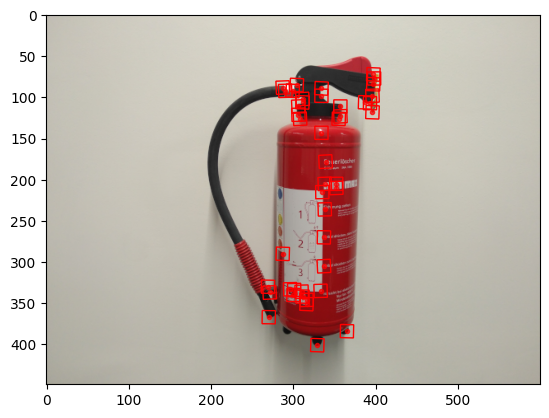

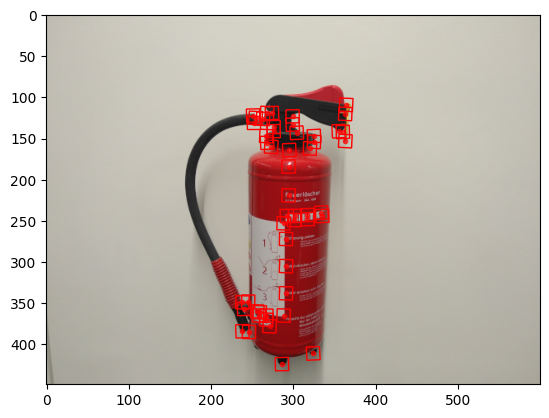

In [40]:
### Show the result
def plot_patches(img, keypoints, angles, patch_size=16):
    """
    :param img: image
    :param keypoints: Numpy array containig the keypoints
    :param rotations: Numpy array of length=len(keypoints) containing
                      the patch rotation
    """
    scales = np.ones(len(keypoints))*patch_size
    ax = plt.gca()
    ax.imshow(img)
    ax.scatter(POINTS[:, 0], POINTS[:, 1], marker='.', alpha=0.7, color='r')
    for kp, angle, length in zip(keypoints, angles, scales):
        rect = patches.Rectangle(kp - length / 2, length, length, linewidth=1,
                                 edgecolor='r', facecolor='none')
        transform = Affine2D().rotate_deg_around(*kp, angle) + ax.transData
        rect.set_transform(transform)
        ax.add_patch(rect)

    plt.show()

## detecting the coner
KEY_POINTS = {}
for i, target_image in  enumerate([rgb2gray(VIEW1), rgb2gray(VIEW2)]):
    POINTS, ANGLES = harris_conner_detector(target_image, window_size=5, threshold=10)
    KEY_POINTS[f"view{i + 1}"] = (POINTS, ANGLES)

## create patches
for i, target_image in  enumerate([VIEW1, VIEW2]):
    POINTS, ANGLES = KEY_POINTS[f"view{i + 1}"]
    plot_patches(target_image, POINTS, ANGLES, patch_size=16)

# Image matching

# Global alignment

# Blending and Compositing

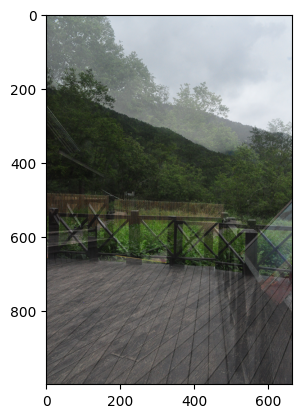

In [8]:
def composite_images(image1, image2):
    """
    Composites two images into one.

    Parameters:
        image1 (np.array): The first image to composite.
        image2 (np.array): The second image to composite.

    Returns:
        np.array: The composited image.
    """
    # Convert the images to 3 channels if they are grayscale
    if len(image1.shape) == 2:
        image1 = cv2.cvtColor(image1, cv2.COLOR_GRAY2BGR)
    if len(image2.shape) == 2:
        image2 = cv2.cvtColor(image2, cv2.COLOR_GRAY2BGR)

    # Resize the images to the same shape
    height, width, channels = image1.shape
    image2 = cv2.resize(image2, (width, height))

    # Blend the images together
    alpha = 0.5
    composite_image = cv2.addWeighted(image1, alpha, image2, (1 - alpha), 0)

    return composite_image

composed_image = composite_images(VIEW1, VIEW2)
plt.imshow(composed_image)
plt.show()

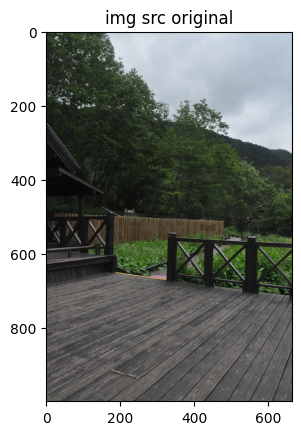

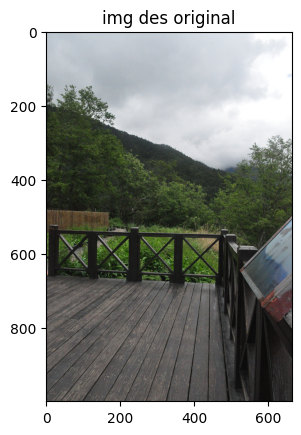

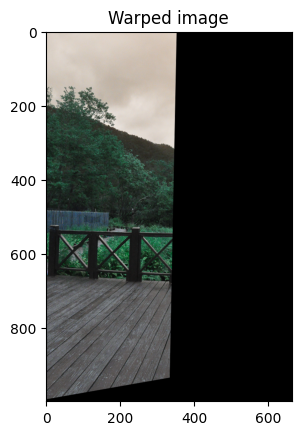

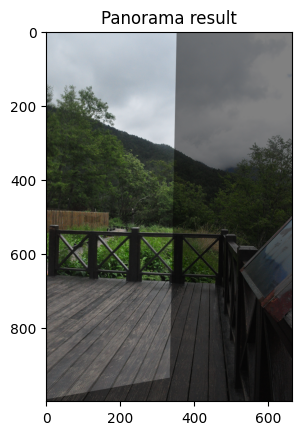

In [32]:
def stitching_images_harris_test():
    # Load images. CV2 reads in BGR format
    img_src = cv2.imread("data/xue-mountain/01.jpg", cv2.IMREAD_UNCHANGED)
    img_des = cv2.imread("data/xue-mountain/02.jpg", cv2.IMREAD_UNCHANGED)
    plt.imshow(cv2.cvtColor(img_src, cv2.COLOR_BGR2RGB))
    plt.title('img src original')
    plt.show()
    plt.imshow(cv2.cvtColor(img_des, cv2.COLOR_BGR2RGB))
    plt.title('img des original')
    plt.show()
    # Normalize values, change data type
    img_src_norm = img_src / np.max(img_src)
    img_des_norm = img_des / np.max(img_des)
    img_src_norm_uint8 = (img_src_norm * 255).astype(np.uint8)
    img_des_norm_uint8 = (img_des_norm * 255).astype(np.uint8)
    """
    plt.imshow(img_src_norm_uint8)
    plt.title('img src uint8')
    plt.show()
    plt.imshow(img_des_norm_uint8)
    plt.title('img des uint8')
    plt.show()
    """
    # Grayscale images
    gray_src = cv2.cvtColor(img_src_norm_uint8, cv2.COLOR_BGR2GRAY)
    gray_des = cv2.cvtColor(img_des_norm_uint8, cv2.COLOR_BGR2GRAY)
    """
    plt.imshow(gray_src)
    plt.title('gray src')
    plt.show()
    plt.imshow(gray_des)
    plt.title('gray des')
    plt.show()
    """
    # Find Harris corners in the source image
    src_corners = cv2.cornerHarris(gray_src, 2, 3, 0.04)
    src_corners = cv2.dilate(src_corners, None)

    # Find Harris corners in the destination image
    des_corners = cv2.cornerHarris(gray_des, 2, 3, 0.04)
    des_corners = cv2.dilate(des_corners, None)

    # Find feature points in the source image
    src_points = np.argwhere(src_corners > 0.01 * src_corners.max())
    src_keypoints = [cv2.KeyPoint(float(x[1]), float(x[0]), 1) for x in src_points]

    # Find feature points in the destination image
    des_points = np.argwhere(des_corners > 0.01 * des_corners.max())
    des_keypoints = [cv2.KeyPoint(float(x[1]), float(x[0]), 1) for x in des_points]

    # Detect descriptors using SIFT
    sift = cv2.SIFT_create()
    src_keypoints, src_descriptors = sift.compute(gray_src, src_keypoints)
    des_keypoints, des_descriptors = sift.compute(gray_des, des_keypoints)

    # Match descriptors using FLANN matcher
    matcher = cv2.FlannBasedMatcher()
    matches = matcher.match(src_descriptors, des_descriptors)

    # Sort matches by distance
    matches = sorted(matches, key=lambda x:x.distance)

    # Select top matches
    num_top_matches = 50
    matches = matches[:num_top_matches]

    # Extract matched keypoints
    src_points = np.float32([src_keypoints[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    des_points = np.float32([des_keypoints[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Compute homography matrix using RANSAC
    H, mask = cv2.findHomography(src_points, des_points, cv2.RANSAC, 10.0)

    # Warp the source image to align with the destination image
    img_warped = cv2.warpPerspective(img_src, H, (img_des.shape[1], img_des.shape[0]))
    plt.imshow(img_warped)
    plt.title('Warped image')
    plt.show()

    # Combine the two images into a panorama
    panorama = np.zeros((max(img_des.shape[0], img_warped.shape[0]), img_des.shape[1] + img_warped.shape[1], 3), dtype=np.uint8)
    panorama[:img_des.shape[0], :img_des.shape[1], :] = img_des
    panorama[:img_warped.shape[0], img_des.shape[1]:, :] = img_warped

    # Blend the two images in the panorama
    alpha = 0.5
    panorama = cv2.addWeighted(panorama[:, :img_des.shape[1], :], alpha, panorama[:, img_des.shape[1]:, :], 1 - alpha, 0)

    # Fix the color channels of the blended image
    panorama = cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB)

    return panorama

HARRIS_IMAGE_RESULT = stitching_images_harris_test()
plt.imshow(HARRIS_IMAGE_RESULT)
plt.title('Panorama result')
plt.show()

# Output

In [41]:
### General code structure

def stitching_images(img_src: np.array, img_des: np.array):
    gd_src = rgb2gray(img_src)
    gd_des = rgb2gray(img_des)

    ### TODO: Harris conner detecting and the patches - areas around conners

    ### TODO: SIFT computing the feature description by gradient of each patch

    ### TODO: Compute distance matrix based on SIFT of each patch

    ### TODO: Match each patch with from distance matrix above

    ### TODO: Run RANSAC to remove the outline pair of patch

    ### TODO: Composite two images into one

    ### TODO: Normalize the images (e.g. have same brightness levels)

    return [combined_image, Harris, num_inliers, residual]